# Cyber Security Attacks Model

The model is supposed to predict a cyber attack type based on user input.

Questions:
- What user input? Which fields can they input? Presumably all fields that are going to be used in final dataset.

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = None

## Data Loading

In [2]:
df = pd.read_csv("../data/cybersecurity_attacks.csv")
df.head(3)

,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,Malware Indicators,Anomaly Scores,Alerts/Warnings,Attack Type,Attack Signature,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall


In [3]:
df.columns = [x.lower() for x in df.columns]
df.columns = df.columns.str.replace('/', "_and_")
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source'],
      dtype='object')

In [4]:
# data from https://ipapi.is/geolocation.html
# last updated March 10, 2025

df_geo = pd.read_csv("../data/geolocationDatabaseIPv4.csv")
df_geo = df_geo.drop_duplicates(subset=['start_ip', 'end_ip', 'country'])
df_geo = df_geo[df_geo['country'].notna()]
df_geo = df_geo[df_geo['start_ip'] != df_geo['end_ip']]
df_geo.head(3)

,ip_version,start_ip,end_ip,continent,country_code,country,state,city,zip,timezone,latitude,longitude,accuracy
0,4,175.103.32.0,175.103.32.255,AS,ID,Indonesia,NaN,Tangerang,NaN,Asia/Jakarta,-6.144135,106.723992,2
1,4,1.178.160.0,1.178.175.255,OC,AU,Australia,New South Wales,Sydney,1001,Australia/Sydney,-33.823931,151.192832,2
2,4,202.9.90.0,202.9.90.255,AS,TH,Thailand,Khon Kaen,Bangkok,40350,Asia/Bangkok,13.738564,100.524805,2


## Exploration

### Data Extraction

Before exploring the data entirely, there are 4 columns that extra data can be extracted from:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

#### Timestamp

In [5]:
df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
df['day_of_week'] = pd.to_datetime(df['timestamp']).dt.dayofweek
df['quarter'] = pd.to_datetime(df['timestamp']).dt.quarter
df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4


#### IP Addresses

The 2 IP Address columns can be used to extract more valuable data. According to https://ipinfo.io/blog/ip-address-information, we can get information like location, ISP, network info (ASN and its type - ASN is a block of IPs owned by an org, hostname, number of domains on IP, privacy detection - coming from VPN or proxy).

Most of the data is behind a paywall except for the geolocation data. Although, data like ASN and IP addresses known for attacks could be useful.

In our case, a downloaded database is used to compare with the help of a package: https://pypi.org/project/ipaddress/

In [6]:
import ipaddress

def ip_to_int(ip_address):
    ip_cleaned = '.'.join(str(int(octet)) for octet in ip_address.split('.'))
    return int(ipaddress.IPv4Address(ip_cleaned))

for col in ['start_ip', 'end_ip']:
    df_geo[f"{col}_int"] = df_geo[col].apply(ip_to_int)

for col in ['source_ip_address', 'destination_ip_address']:
    df[f"{col}_int"] = df[col].apply(ip_to_int)
    
df_geo = df_geo.sort_values('start_ip_int').reset_index(drop=True)

geo_start_ips = df_geo['start_ip_int'].values
geo_end_ips = df_geo['end_ip_int'].values

In [7]:
for loc in ['source','destination']:
    
    # this will match all rows all rows with vals from start_ips. there is no upper limit so all rows will be filled.
    indeces = np.searchsorted(
        geo_start_ips,
        df[f'{loc}_ip_address_int'].values,
        side='right',
    ) - 1 

    # the solution for the above problem is to create a mask where False will be given if it does not fit with the end_ip too.
    mask = (indeces >= 0) & (df[f'{loc}_ip_address_int'].values < geo_end_ips[indeces])

    # for loop is used to check the remaining false values
    # not used for entire algorithm because the for loop method is inefficient
    for i in range(len(mask)):
        if not mask[i]:
            ip_address = df[f'{loc}_ip_address_int'][i]
            geo_row = df_geo.loc[(df_geo['start_ip_int'] <= ip_address) & (df_geo['end_ip_int'] >= ip_address)]
    
            if not geo_row.empty:
                indeces[i] = geo_row.index[0]
                mask[i] = not mask[i]
        
    matched_countries = np.where(mask, df_geo['country'].values[indeces], None)
    df[f'{loc}_country'] = matched_countries

df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter,source_ip_address_int,destination_ip_address_int,source_country,destination_country
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2,1742212876,1409918204,China,United Kingdom
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3,1321720262,1119848858,France,United States
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4,1062195760,3336262161,United States,None


#### Device Information

The values in this column has information in the form of user agents. We can extract info like browser, operating system, device model, etc.

Something to keep in mind is that data this type of data can be easily faked but can still point towards an anomaly.

There is Python package that can parse this data: https://pypi.org/project/user-agents/

Initially, the data inlcuded versions for each type making the data very specific and the column values were too broad.
Browser accrued 5490 results
OS accrued 174 results. While more manageable, the data within the versions seemed to be evenly spread within each OS family.
Device accrued only 8 device types - most types were Apple based, but the type "Other None None" was more than half of the dataset.ie. > 20000.
This can skew the dataset but it might be useful to group the Apple devices and use Other None None as another category.

To regenerate the data as described above, you can use the following code:
```
df = df.assign(**{"Browser": df["Device Information"].apply(lambda x : parse(x).browser.family + " " + parse(x).browser.version_string)})
df = df.assign(**{"OS": df["Device Information"].apply(lambda x : parse(x).os.family + " " + parse(x).os.version_string)})
df = df.assign(**{'Device': df['Device Information'].apply(lambda x : str(parse(x).device.family) + " " + str(parse(x).device.brand) + " " + str(parse(x).device.model))})
```

In [8]:
from user_agents import parse

df = df.assign(browser=df['device_information'].apply(lambda x : parse(x).browser.family))
df = df.assign(os=df['device_information'].apply(lambda x : parse(x).os.family))

df.head(3)

,timestamp,source_ip_address,destination_ip_address,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,user_information,device_information,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter,source_ip_address_int,destination_ip_address_int,source_country,destination_country,browser,os
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2,1742212876,1409918204,China,United Kingdom,IE,Windows
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3,1321720262,1119848858,France,United States,IE,Windows
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4,1062195760,3336262161,United States,None,IE,Windows


### Raw Data

In [9]:
df.columns

Index(['timestamp', 'source_ip_address', 'destination_ip_address',
       'source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'malware_indicators',
       'anomaly_scores', 'alerts_and_warnings', 'attack_type',
       'attack_signature', 'action_taken', 'severity_level',
       'user_information', 'device_information', 'network_segment',
       'geo-location_data', 'proxy_information', 'firewall_logs',
       'ids_and_ips_alerts', 'log_source', 'hour', 'day_of_week', 'quarter',
       'source_ip_address_int', 'destination_ip_address_int', 'source_country',
       'destination_country', 'browser', 'os'],
      dtype='object')

In [10]:
df.describe()

,source_port,destination_port,packet_length,anomaly_scores,hour,day_of_week,quarter,source_ip_address_int,destination_ip_address_int
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,4.000000e+04,4.000000e+04
mean,32970.356450,33150.868650,781.452725,50.113473,11.507350,2.995750,2.429150,1.883090e+09,1.888752e+09
std,18560.425604,18574.668842,416.044192,28.853598,6.919122,2.004515,1.085246,1.082714e+09,1.082598e+09
min,1027.000000,1024.000000,64.000000,0.000000,0.000000,0.000000,1.000000,1.685447e+07,1.689131e+07
25%,16850.750000,17094.750000,420.000000,25.150000,5.000000,1.000000,1.000000,9.452909e+08,9.543111e+08
50%,32856.000000,33004.500000,782.000000,50.345000,12.000000,3.000000,2.000000,1.868979e+09,1.877675e+09
75%,48928.250000,49287.000000,1143.000000,75.030000,17.000000,5.000000,3.000000,2.826388e+09,2.832564e+09
max,65530.000000,65535.000000,1500.000000,100.000000,23.000000,6.000000,4.000000,3.757965e+09,3.758075e+09


In [11]:
dups = df.duplicated()
dups[dups == True]

Series([], dtype: bool)

In [12]:
df.nunique()

timestamp                     39997
source_ip_address             40000
destination_ip_address        40000
source_port                   29761
destination_port              29895
protocol                          3
packet_length                  1437
packet_type                       2
traffic_type                      3
payload_data                  40000
malware_indicators                1
anomaly_scores                 9826
alerts_and_warnings               1
attack_type                       3
attack_signature                  2
action_taken                      3
severity_level                    3
user_information              32389
device_information            32104
network_segment                   3
geo-location_data              8723
proxy_information             20148
firewall_logs                     1
ids_and_ips_alerts                1
log_source                        2
hour                             24
day_of_week                       7
quarter                     

In [13]:
# reusable function
def show_nulls():
    null_count = df.isna().sum()
    print(null_count[null_count > 0])

show_nulls()

malware_indicators     20000
alerts_and_warnings    20067
proxy_information      19851
firewall_logs          19961
ids_and_ips_alerts     20050
source_country          5171
destination_country     5152
dtype: int64


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   timestamp                   40000 non-null  object 
 1   source_ip_address           40000 non-null  object 
 2   destination_ip_address      40000 non-null  object 
 3   source_port                 40000 non-null  int64  
 4   destination_port            40000 non-null  int64  
 5   protocol                    40000 non-null  object 
 6   packet_length               40000 non-null  int64  
 7   packet_type                 40000 non-null  object 
 8   traffic_type                40000 non-null  object 
 9   payload_data                40000 non-null  object 
 10  malware_indicators          20000 non-null  object 
 11  anomaly_scores              40000 non-null  float64
 12  alerts_and_warnings         19933 non-null  object 
 13  attack_type                 400

## Initial Data Cleaning

Columns that immediately stand out as unnecessary are the ones that were used to extract data:
- timestamp
- source_ip_address
- destination_ip_address
- device_information

Then the columns that aren't as useful, especially those with a high value count that are hard to classify such as:
- user_information

In [15]:
columns_to_drop = [
    'timestamp', 'source_ip_address', 'source_ip_address_int', 'destination_ip_address',
    'destination_ip_address_int', 'device_information', 'user_information'
]
df.drop(columns_to_drop, axis=1, inplace=True)

## Analysis (almost)

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

From the raw stats shown previously, we can determine the following:
- No duplicated rows.

**Need Clarity**

- From whose perspective is the data from? The victim?
- Is timestamp using UTC time or some other uniform time zone?
- Is the action_taken column showing actions done by the system after the attack happened and before human intervention?

**Further Analysis**

- Are countries relevant? Because we don't know if the data collection is concentrated in a certain area. Model results can be skewed.
- Ports above a certain value can be used for anything unlike the ports below that threshold. Can we assume that the ports selected are randomly assigned by the attacker?
- Packet Type has some relation to Protocol. Do some more checks to make sure.
- Checks on Packet Length.
- Checks on payload_data to see if there are any patterns within them. It looks like irrelevant latin text - possibly auto-generated.
- Check which values from some other column are paired with Malware Indicators.
- What is the Anomaly Score? Not sure which part of the process it is in. How does it relate to Attack Signatures?
- Can we group the different types of alerts? Or do they specifically indicate which type of attack there is. Or can we group them into a single column where the value will be true once 1 of the alert columns has a True value?

### Device Information

Upon further analysis:
- another column can be created for to see if the device is a mobile or not (bool).
  - before the next step, look for discrepancies between os and browser type since we know that the data can be faked.
- the browser column can be simplified by grouping the browsers together like "Chrome" and "Chrome Mobile iOS" as one family.

In [17]:
df['os'].value_counts()

os
Windows     17953
Linux        7171
Mac OS X     5813
iOS          5774
Android      3289
Name: count, dtype: int64

In [18]:
df['browser'].value_counts()

browser
Opera                8049
IE                   7995
Chrome               6501
Safari               5314
Firefox              4747
Mobile Safari        2656
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

In [19]:
browsers = df['browser'].unique()

def is_mobile_browser(browser_name):
    return any(c.isspace() for c in browser_name)

browser_families = [x for x in browsers if not is_mobile_browser(x)]

def is_mobile_os(os_name):
    mobile_os = ["iOS", "Android"]
    return any(os_name in x for x in mobile_os)

def get_browser_family(browser_name):
    if is_mobile_browser(browser_name):
        for family in browser_families:
            if family in browser_name:
                return family
    else:
        return browser_name

In [20]:
df = df.assign(is_mobile=df['os'].apply(is_mobile_os))
df = df.assign(is_mobile_browser=df['browser'].apply(is_mobile_browser))

In [21]:
# checking all browsers linked to mobile devices
df_mobile = df[df['is_mobile']==True]
df_mobile['browser'].value_counts()

browser
Mobile Safari        2656
Chrome               1669
Firefox Mobile       1620
Chrome Mobile iOS    1604
Firefox iOS          1514
Name: count, dtype: int64

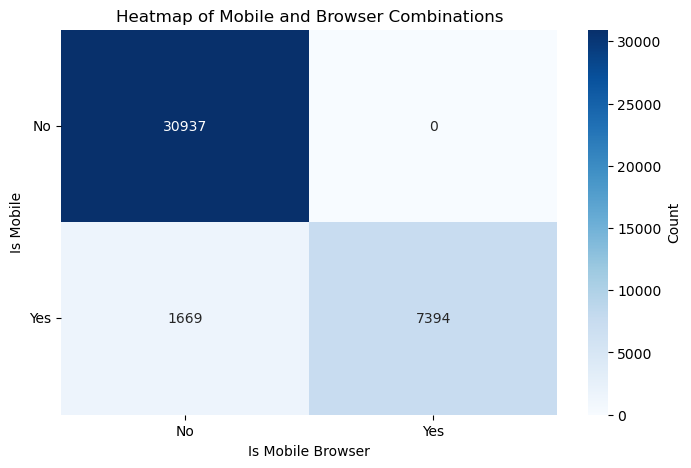

In [22]:
contingency_table = pd.crosstab(df['is_mobile'], df['is_mobile_browser'])

plt.figure(figsize=(8, 5))
sns.heatmap(contingency_table, annot=True, cmap='Blues', fmt='g', cbar_kws={'label':"Count"})
plt.title("Heatmap of Mobile and Browser Combinations")
plt.xlabel("Is Mobile Browser")
plt.ylabel("Is Mobile")
plt.xticks([0.5, 1.5], ["No", "Yes"], rotation=0)
plt.yticks([0.5, 1.5], ["No", "Yes"], rotation=0)
plt.show()

In [23]:
# this is done here because this change would affect the results of the cell checking for browsers linked to mobile
# the goal of the previous cell is to see if there are any non-mobile browsers
df['browser'] = df['browser'].apply(get_browser_family)
df.head(3)

,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,malware_indicators,anomaly_scores,alerts_and_warnings,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,proxy_information,firewall_logs,ids_and_ips_alerts,log_source,hour,day_of_week,quarter,source_country,destination_country,browser,os,is_mobile,is_mobile_browser
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,IoC Detected,28.67,NaN,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server,6,1,2,China,United Kingdom,IE,Windows,False,False
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,IoC Detected,51.50,NaN,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall,7,2,3,France,United States,IE,Windows,False,False
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,IoC Detected,87.42,Alert Triggered,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall,8,6,4,United States,None,IE,Windows,False,False


### Categorical Columns

In [24]:
def get_categorical_vals():
    values_unique = df.nunique()
    categorical_possible = values_unique[values_unique < 10]
    
    for col_name, val_count in categorical_possible.items():
        msg = ""
        col_unique_vals = df[col_name].unique()
        
        if val_count == 1:
            col_unique_vals = [x for x in col_unique_vals if not pd.isnull(x)]
            msg = "Removed null value. Possible boolean?"
            
        print(f"{col_name}, Values: {col_unique_vals} {msg}")

get_categorical_vals()

protocol, Values: ['ICMP' 'UDP' 'TCP'] 
packet_type, Values: ['Data' 'Control'] 
traffic_type, Values: ['HTTP' 'DNS' 'FTP'] 
malware_indicators, Values: ['IoC Detected'] Removed null value. Possible boolean?
alerts_and_warnings, Values: ['Alert Triggered'] Removed null value. Possible boolean?
attack_type, Values: ['Malware' 'DDoS' 'Intrusion'] 
attack_signature, Values: ['Known Pattern B' 'Known Pattern A'] 
action_taken, Values: ['Logged' 'Blocked' 'Ignored'] 
severity_level, Values: ['Low' 'Medium' 'High'] 
network_segment, Values: ['Segment A' 'Segment B' 'Segment C'] 
firewall_logs, Values: ['Log Data'] Removed null value. Possible boolean?
ids_and_ips_alerts, Values: ['Alert Data'] Removed null value. Possible boolean?
log_source, Values: ['Server' 'Firewall'] 
day_of_week, Values: [1 2 6 4 0 5 3] 
quarter, Values: [2 3 4 1] 
browser, Values: ['IE' 'Firefox' 'Opera' 'Chrome' 'Safari'] 
os, Values: ['Windows' 'Mac OS X' 'Linux' 'iOS' 'Android'] 
is_mobile, Values: [False  True] 
i

From the data generated above, we can see that some columns have few unique values. These values can indicate categories and therefore, they can be encoded making it easier for the algorithms to understand.
Both ordinal and nominal encoding should be considered.

Possible fields for ordinal encoding: severity_level

In addition that that, there are columns that contain only 1 unique value; usually the single value and others are populated by null values. Those columns can be possibly used as booleans. proxy_information is another good contender for a boolean since we won't need the exact values but rather if a proxy was detected.

In [25]:
df['has_proxy'] = np.where(df['proxy_information'].notnull(), True, False)
df['has_malware_indicator'] = np.where(df['malware_indicators'].notnull(), True, False)
df['has_alerts_and_warnings'] = np.where(df['alerts_and_warnings'].notnull(), True, False)
df['has_firewall_log'] = np.where(df['firewall_logs'].notnull(), True, False)
df['has_ids_ips_alert'] = np.where(df['ids_and_ips_alerts'].notnull(), True, False)

# drop original
columns_to_drop = ['malware_indicators', 'alerts_and_warnings', 'proxy_information', 'firewall_logs', 'ids_and_ips_alerts']
df.drop(columns_to_drop, axis=1, inplace=True)

show_nulls()
df.head(3)

source_country         5171
destination_country    5152
dtype: int64


,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,anomaly_scores,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,log_source,hour,day_of_week,quarter,source_country,destination_country,browser,os,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,28.67,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",Server,6,1,2,China,United Kingdom,IE,Windows,False,False,True,True,False,True,False
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,51.50,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",Firewall,7,2,3,France,United States,IE,Windows,False,False,False,True,False,True,False
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,87.42,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",Firewall,8,6,4,United States,None,IE,Windows,False,False,True,True,True,True,True


We can see that 4 out of the 5 new bools are related to alerts so a new column can be created to concat them - if at least 1 is true, then the new column, has_system_alert, will be true.
Additionally, we can get an count of all alerts into a new column, alert_count.

In [26]:
def has_system_alert(row):
    return True if row['has_malware_indicator'] or row['has_alerts_and_warnings'] or row['has_firewall_log'] or row['has_ids_ips_alert'] else False

def count_alerts(row):
    count = 0

    if row['has_malware_indicator']:
        count+=1
    if row['has_alerts_and_warnings']:
        count+=1
    if row['has_firewall_log']:
        count+=1
    if row['has_ids_ips_alert']:
        count+=1
        
    return count
    
df['has_system_alert'] = df.apply(has_system_alert, axis=1)
df['alert_count'] = df.apply(count_alerts, axis=1)

print(df['has_system_alert'].value_counts())
df.head(3)

has_system_alert
True     37490
False     2510
Name: count, dtype: int64


,source_port,destination_port,protocol,packet_length,packet_type,traffic_type,payload_data,anomaly_scores,attack_type,attack_signature,action_taken,severity_level,network_segment,geo-location_data,log_source,hour,day_of_week,quarter,source_country,destination_country,browser,os,is_mobile,is_mobile_browser,has_proxy,has_malware_indicator,has_alerts_and_warnings,has_firewall_log,has_ids_ips_alert,has_system_alert,alert_count
0,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,28.67,Malware,Known Pattern B,Logged,Low,Segment A,"Jamshedpur, Sikkim",Server,6,1,2,China,United Kingdom,IE,Windows,False,False,True,True,False,True,False,True,2
1,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,51.50,Malware,Known Pattern A,Blocked,Low,Segment B,"Bilaspur, Nagaland",Firewall,7,2,3,France,United States,IE,Windows,False,False,False,True,False,True,False,True,2
2,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,87.42,DDoS,Known Pattern B,Ignored,Low,Segment C,"Bokaro, Rajasthan",Firewall,8,6,4,United States,None,IE,Windows,False,False,True,True,True,True,True,True,4


Well... based on the value_counts on has_system_alert, it looks useless, lol.

### Networking Stuff

The columns: protocol, packet_length, packet_type, traffic_type, payload_data can be combined somehow to create one or a few new columns.

### Payload Data

The data could contain signs of an attack.

In [27]:
# df['payload_data'].tolist()[10000:10010]

### Countries

There is missing data in the countries columns. Investigate.

In [28]:
show_nulls()

source_country         5171
destination_country    5152
dtype: int64


Since about 13% of the countries are empty, we can fill them with the modal value just to ensure the columns are filled for future tests.

In [29]:
df['source_country'].fillna(df['source_country'].mode()[0], inplace=True)
df['destination_country'].fillna(df['destination_country'].mode()[0], inplace=True)
show_nulls()

Series([], dtype: int64)


### Class Distribution (for target)

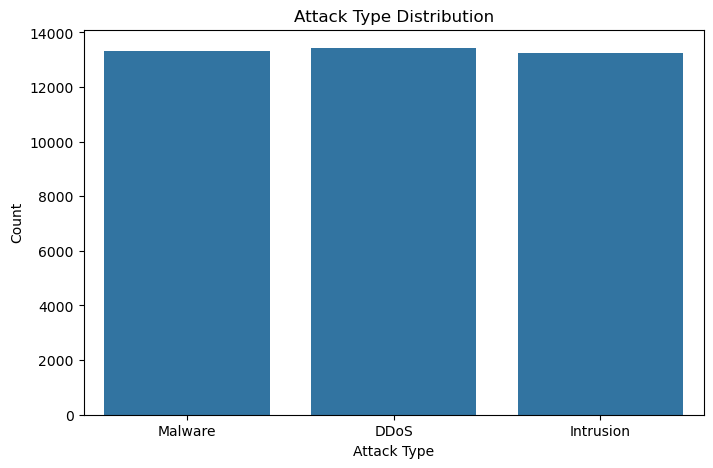

In [30]:
plt.figure(figsize=(8,5))
sns.countplot(x=df['attack_type'])
plt.title('Attack Type Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.show()

The graph above shows that the target variables are uniform.

## Analysis

In [31]:
df.columns

Index(['source_port', 'destination_port', 'protocol', 'packet_length',
       'packet_type', 'traffic_type', 'payload_data', 'anomaly_scores',
       'attack_type', 'attack_signature', 'action_taken', 'severity_level',
       'network_segment', 'geo-location_data', 'log_source', 'hour',
       'day_of_week', 'quarter', 'source_country', 'destination_country',
       'browser', 'os', 'is_mobile', 'is_mobile_browser', 'has_proxy',
       'has_malware_indicator', 'has_alerts_and_warnings', 'has_firewall_log',
       'has_ids_ips_alert', 'has_system_alert', 'alert_count'],
      dtype='object')

In [32]:
get_categorical_vals()

protocol, Values: ['ICMP' 'UDP' 'TCP'] 
packet_type, Values: ['Data' 'Control'] 
traffic_type, Values: ['HTTP' 'DNS' 'FTP'] 
attack_type, Values: ['Malware' 'DDoS' 'Intrusion'] 
attack_signature, Values: ['Known Pattern B' 'Known Pattern A'] 
action_taken, Values: ['Logged' 'Blocked' 'Ignored'] 
severity_level, Values: ['Low' 'Medium' 'High'] 
network_segment, Values: ['Segment A' 'Segment B' 'Segment C'] 
log_source, Values: ['Server' 'Firewall'] 
day_of_week, Values: [1 2 6 4 0 5 3] 
quarter, Values: [2 3 4 1] 
browser, Values: ['IE' 'Firefox' 'Opera' 'Chrome' 'Safari'] 
os, Values: ['Windows' 'Mac OS X' 'Linux' 'iOS' 'Android'] 
is_mobile, Values: [False  True] 
is_mobile_browser, Values: [False  True] 
has_proxy, Values: [ True False] 
has_malware_indicator, Values: [ True False] 
has_alerts_and_warnings, Values: [False  True] 
has_firewall_log, Values: [ True False] 
has_ids_ips_alert, Values: [False  True] 
has_system_alert, Values: [ True False] 
alert_count, Values: [2 4 0 1 3]

### Some Preprocessing - Encoding
For now, only columns that can be ordinally encoded will be encoded.

The one that stands out is severity_level. Maybeee action_taken can be considered.

In [33]:
from sklearn.preprocessing import OrdinalEncoder

order = ['Low', 'Medium', 'High']
oe = OrdinalEncoder(categories=[order])
df['severity_level']= oe.fit_transform(df[['severity_level']])

### Feature Correlation with Attack Type

We can check categorical using chi squared, then numerical using...

"The Chi-square test is a statistical test that is used to determine whether there is a significant difference between the observed frequency of a categorical variable and the expected frequency based on the assumption of independence. It can be used to select the best categorical features for a classification model."
From: https://datascience.stackexchange.com/questions/117287/are-chi-square-and-anova-f-classif-to-select-best-features

"The Chi-Square test determines whether there is a significant association between two categorical variables. It helps in hypothesis testing to check whether observed frequencies differ from expected ones."
"If the p-value is less than the significance level (typically 0.05), reject the null hypothesis, indicating a significant relationship between the variables.
If the p-value is greater than 0.05, fail to reject the null hypothesis, meaning no significant relationship was found."
From: https://www.simplilearn.com/tutorials/statistics-tutorial/chi-square-test

In [34]:
categorical_features = [
    'protocol', 'packet_type', 'traffic_type', 'attack_signature', 'action_taken',
    'severity_level', 'network_segment', 'geo-location_data', 'log_source', 'hour',
    'day_of_week', 'quarter', 'source_country', 'destination_country', 'browser',
    'os', 'is_mobile', 'is_mobile_browser', 'has_malware_indicator', 'has_alerts_and_warnings',
    'has_proxy', 'has_firewall_log', 'has_ids_ips_alert', 'has_system_alert'
]

numeric_features = ['source_port', 'destination_port', 'packet_length','anomaly_scores', 'alert_count']

In [35]:
from scipy.stats import chi2_contingency

def chi_square_test(feature):
    contingency_table = pd.crosstab(df[feature], df['attack_type'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return feature, chi2, p

chi_square_results = [chi_square_test(feature) for feature in categorical_features]

chi_square_df = pd.DataFrame(chi_square_results, columns=['feature', 'chi2', 'p'])

,feature,chi2,p
1,packet_type,5.992260,0.049980
14,browser,16.683922,0.033574
17,is_mobile_browser,7.725519,0.021010


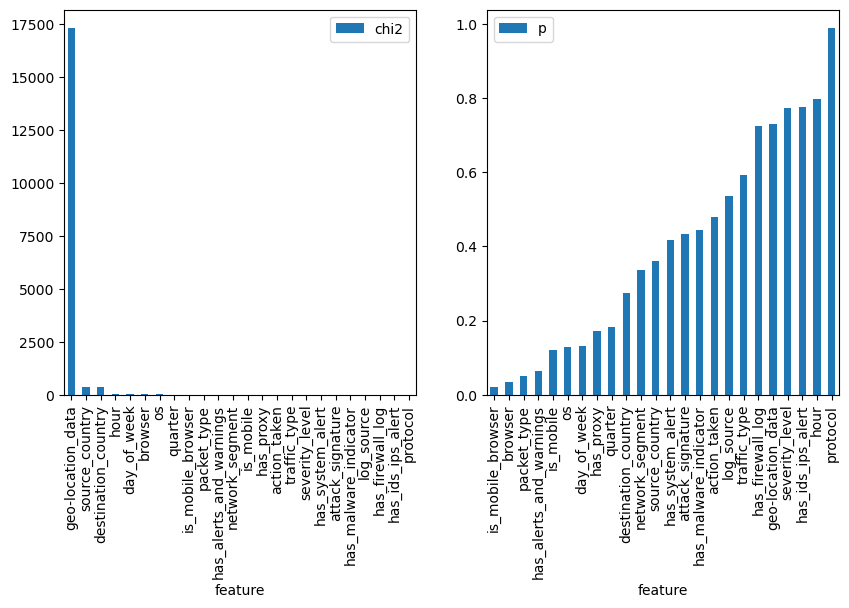

<Figure size 2000x1000 with 0 Axes>

In [36]:
fig, axs = plt.subplots(1,2)
plt.figure(figsize=(20,10))
chi2_df = chi_square_df.sort_values(by='chi2', ascending=False)
pv_df = chi_square_df.sort_values(by='p', ascending=True) 
chi2_df.plot.bar(x='feature', y='chi2', figsize=(10,5), ax=axs[0])
pv_df.plot.bar(x='feature', y='p', ax=axs[1])

# features with p-values < 0.05 are statistically significant
chi_square_df[chi_square_df['p'] < 0.05]

## Model

In test stages only. Just to see what happens. Not meant to produce a usable model.

In [37]:
from sklearn.preprocessing import OneHotEncoder

cols_model = [
    'attack_type', 'packet_type', 'browser', 'is_mobile_browser', 'is_mobile', 'os', 'protocol', 'attack_signature'
]
df_model = df[cols_model]

X_no_encode = df_model.drop(columns=['attack_type'])

ohe=OneHotEncoder(sparse_output=False, handle_unknown='error')
X_encoded = ohe.fit_transform(X_no_encode)

categorical_columns = [f'{col}_{cat}' for i, col in enumerate(X_no_encode.columns) for cat in ohe.categories_[i]]

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = pd.DataFrame(X_encoded, columns=categorical_columns)
y = df_model['attack_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        DDoS       0.35      0.40      0.38      2686
   Intrusion       0.34      0.27      0.30      2653
     Malware       0.34      0.37      0.36      2661

    accuracy                           0.35      8000
   macro avg       0.35      0.35      0.34      8000
weighted avg       0.35      0.35      0.35      8000



In [40]:
import time

start_time = time.time()
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.008 seconds


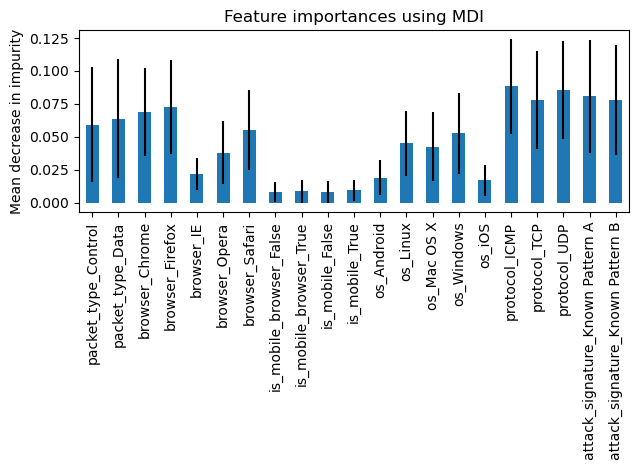

In [43]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_importances = pd.Series(importances, index=categorical_columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()